# Counterfactuals in Latent Space

In [162]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src')
# You can run the explainers locally
from explainers_lib.explainers.wachter import WachterExplainer
from explainers_lib.explainers.growing_spheres import GrowingSpheresExplainer

# Or you can run it via celery, or even run some locally and some via celery
# from explainers_lib.explainers.celery_explainer import WachterExplainer
# from explainers_lib.explainers.celery_explainer import GrowingSpheresExplainer
from explainers_lib.explainers.celery_explainer import ActionableRecourseExplainer
from explainers_lib.explainers.celery_explainer import FaceExplainer
from explainers_lib.explainers.celery_explainer import DiceExplainer
from explainers_lib.explainers.celery_explainer import AlibiCFProto
from explainers_lib.explainers.celery_explainer import AlibiCFRL

from explainers_lib.model import TorchModel as ExplainerModel
from explainers_lib.datasets import Dataset
from explainers_lib.aggregators import All
from explainers_lib.ensemble import Ensemble



In [163]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cpu


## Load MNIST data

In [164]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


## Black-box model

### Train CNN model

In [165]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        
        x = self.fc2(x)
        
        return x


In [166]:
cnn_model_path = 'models/torch_cnn_mnist.pth'
if not os.path.exists('models'):
    os.makedirs('models')

cnn = CNN().to(device)
if os.path.exists(cnn_model_path):
    cnn.load_state_dict(torch.load(cnn_model_path))
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    for epoch in range(5):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, CNN Loss: {running_loss / len(train_loader)}')
    torch.save(cnn.state_dict(), cnn_model_path)
cnn.eval()


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Train Autoencoder

In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- THIS IS THE UPDATED ENCODER ---
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        
        # Split the final layer into two heads
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        
        # Output mu and log_var instead of a single vector
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        return mu, log_var


In [168]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128) # Use latent_dim
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 32 * 7 * 7)
        self.relu2 = nn.ReLU()
        self.t_conv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.relu3 = nn.ReLU()
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = x.view(-1, 32, 7, 7)
        x = self.relu3(self.t_conv1(x))
        # Using sigmoid is more common for [0, 1] normalized images
        # but tanh is fine if your images are [-1, 1]
        x = torch.tanh(self.t_conv2(x)) 
        return x


In [169]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, log_var):
        """
        The reparameterization trick.
        z = mu + eps * std
        """
        # std = exp(0.5 * log_var)
        std = torch.exp(0.5 * log_var)
        # eps is a random tensor with the same shape as std
        eps = torch.randn_like(std)
        
        return mu + eps * std

    def forward(self, x):
        # 1. Encode x to mu and log_var
        mu, log_var = self.encoder(x)
        
        # 2. Sample z from the distribution N(mu, std)
        z = self.reparameterize(mu, log_var)
        
        # 3. Decode z back to an image
        reconstruction = self.decoder(z)
        
        # Return all parts needed for the loss
        return reconstruction, mu, log_var


In [170]:
import torch.optim as optim

# --- Example Training Setup ---

# Define a latent dimension
LATENT_DIM = 16

# Assume 'train_loader' and 'device' exist
# train_loader = ...
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Instantiate the models
encoder = VAE_Encoder(latent_dim=LATENT_DIM).to(device)
decoder = Decoder(latent_dim=LATENT_DIM).to(device)
vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)

# --- Define the new VAE loss function ---
def vae_loss_function(reconstruction, original_images, mu, log_var):
    # 1. Reconstruction Loss (how well it rebuilt the image)
    # We use 'sum' reduction because we sum the KLD loss
    recon_loss = F.mse_loss(reconstruction, original_images, reduction='sum')

    # 2. KL Divergence (how far the latent space is from a perfect Gaussian)
    # This is the standard formula
    # 0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss
    return recon_loss + kld_loss


# 3. The new training loop
vae.train()
for epoch in range(50):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        
        # --- Forward Pass ---
        # The model now returns 3 items
        reconstructions, mu, log_var = vae(images)
        
        # --- Calculate Loss ---
        loss = vae_loss_function(reconstructions, images, mu, log_var)
        
        # --- Backward Pass ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, VAE Loss: {avg_loss:.4f}')

vae.eval()
print("Training complete.")

# --- How to generate new images ---
print("Generating new images from noise...")
with torch.no_grad():
    # Sample 16 random vectors from a standard Gaussian
    noise = torch.randn(16, LATENT_DIM).to(device)
    
    # Decode the noise
    generated_images = vae.decoder(noise)
    
    # 'generated_images' will now be feasible!
    # (You can use torchvision.utils.save_image or similar to view them)


KeyboardInterrupt: 

In [ ]:
ae_model_path = 'models/torch_vae_mnist.pth'
torch.save(vae.state_dict(), ae_model_path)


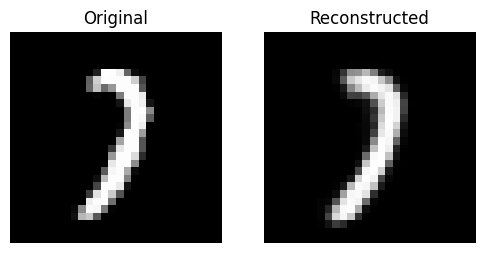

In [ ]:
# --- Example of reconstructing a single image ---

# Make sure the VAE is in evaluation mode
vae.eval()

# 1. Get a single image from your dataset (e.g., from train_loader)
# 'iter' creates an iterator, 'next' gets the first batch
data_iter = iter(train_loader)
images, _ = next(data_iter)

# 2. Select just one image and move it to the device
# We keep the batch dimension [1, 1, 28, 28]
image_to_reconstruct = images[0].unsqueeze(0).to(device) 

# 3. Pass it through the VAE
with torch.no_grad(): # No need to track gradients
    # Get the reconstruction. We can ignore mu and log_var here.
    reconstruction, _, _ = vae(image_to_reconstruct)

# 4. 'reconstruction' now holds the VAE's version of the original image
# You can now plot or save them side-by-side to compare

# --- (Optional) Code to visualize the comparison ---
import matplotlib.pyplot as plt
import torchvision.utils

# Move images back to CPU for plotting
original_np = image_to_reconstruct.cpu().squeeze().numpy()
reconstructed_np = reconstruction.cpu().squeeze().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.imshow(original_np, cmap='gray')
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(reconstructed_np, cmap='gray')
ax2.set_title("Reconstructed")
ax2.axis('off')

plt.show()


## Generate Counterfactuals in Latent Space

In [ ]:
import torch
import torch.nn as nn

class DecoderCNN(nn.Module):
    def __init__(self, decoder, cnn):
        super().__init__() # Initialize the parent nn.Module
        self.decoder = decoder
        self.cnn = cnn

    def forward(self, latent_tensors):
        # Define the data flow
        decoded_images = self.decoder(latent_tensors)
        predictions = self.cnn(decoded_images)
        return predictions


In [ ]:
import torch
import numpy as np
# from ... import Dataset, ExplainerModel # Assuming these imports

class BatchedLatentWrapper(ExplainerModel):
    def __init__(self, decoder, cnn, device):
        # Use the DecoderCNN wrapper class
        model_to_script = DecoderCNN(decoder, cnn)
        
        # 2. Compile it using torch.jit.script()
        # This converts the plain nn.Module into a torch.jit.ScriptModule
        # which has the .save_to_buffer() method.
        self._model = torch.jit.script(model_to_script).to(device)        
        # Set the model to evaluation mode. This is crucial!
        # It turns off things like Dropout and BatchNorm updates.
        self._model.eval() 
        self._torch = torch
        
        self.device = device
        # We no longer need separate self.decoder and self.cnn attributes

    def predict(self, data: Dataset) -> np.ndarray:
        latent_tensors = torch.tensor(data.data, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            # Now you just call your single, combined model
            predictions = self._model(latent_tensors)
            
            predicted_classes = torch.argmax(predictions, dim=1)
            
        return predicted_classes.cpu().numpy()


In [ ]:
iteracja = iter(test_loader)


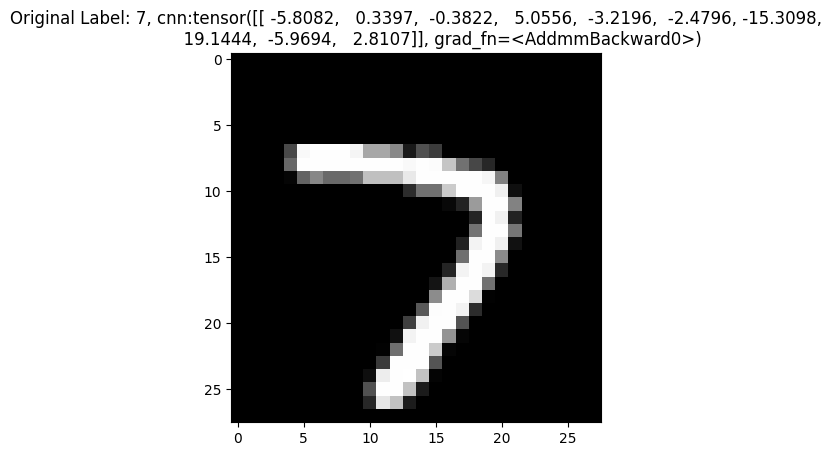

In [ ]:
_ = next(iteracja)

images, labels = next(iteracja)
instance_to_explain = images[0:1].to(device)
original_label = labels[0].item()

plt.imshow(instance_to_explain.cpu().squeeze().numpy(), cmap='gray')
plt.title(f'Original Label: {original_label}, cnn:{cnn(images[0:1].to(device))}')
plt.show()


In [ ]:
latent_wrapper = BatchedLatentWrapper(decoder, cnn, device)


In [ ]:
ensemble = Ensemble(
    latent_wrapper,
    [WachterExplainer(lambda_param=1000), GrowingSpheresExplainer(step_size=0.1, max_radius=1000, num_samples=20),                   # Local explainers
    #  ActionableRecourseExplainer(), FaceExplainer(), # Carla explainers
    #  AlibiCFProto(), AlibiCFRL()
     ],                                    # Alibi explainers
    All())


In [ ]:
latent_instance = encoder(instance_to_explain)
# print(latent_instance)
latent_instance_np = vae.reparameterize(latent_instance[0], latent_instance[1]).cpu().detach().numpy()

latent_dataset = Dataset(
    data=latent_instance_np,
    target=[original_label],
    features=[f'l{i}' for i in range(16)],
    categorical_features=[],
    continuous_features=[f'l{i}' for i in range(16)],
    immutable_features=[],
    allowable_ranges=[]
)

ensemble.fit(latent_dataset)


In [ ]:
latent_instance = encoder(instance_to_explain)
# print(latent_instance)
latent_instance_np = vae.reparameterize(latent_instance[0], latent_instance[1]).cpu().detach().numpy()

latent_dataset = Dataset(
    data=latent_instance_np,
    target=[original_label],
    features=[f'l{i}' for i in range(16)],
    categorical_features=[],
    continuous_features=[f'l{i}' for i in range(16)],
    immutable_features=[],
    allowable_ranges=[]
)



counterfactuals = ensemble.explain(latent_dataset)
counterfactuals


0instance [00:00, ?instance/s]

1instance [00:01,  1.16s/instance]
1instance [00:13, 13.74s/instance]


[Counterfactual(original_data=array([ 0.67821115, -0.44434354,  1.3432504 , -0.20598912, -1.117784  ,
         0.606521  , -1.1678125 , -0.0238422 , -0.55160534,  1.431553  ,
         1.0451422 , -0.38731912, -0.2765539 , -1.152925  , -1.4928362 ,
         2.3974574 ], dtype=float32), data=array([ 2.8911016 ,  2.53953597,  4.01607781, -0.15601371, -0.84319777,
         3.11498501, -0.33915026,  2.78144042, -0.24511055,  2.16117977,
         3.58774251,  2.04945791,  2.08600206,  0.56417695, -0.9413559 ,
         2.55795884]), original_class=np.int64(7), target_class=np.int64(0), explainer='growing_spheres(step_size=0.1, max_radius=100, num_samples=200)'),
 Counterfactual(original_data=array([ 0.67821115, -0.44434354,  1.3432504 , -0.20598912, -1.117784  ,
         0.606521  , -1.1678125 , -0.0238422 , -0.55160534,  1.431553  ,
         1.0451422 , -0.38731912, -0.2765539 , -1.152925  , -1.4928362 ,
         2.3974574 ], dtype=float32), data=array([ 1.63170758,  1.32446079,  1.68242674,

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 0


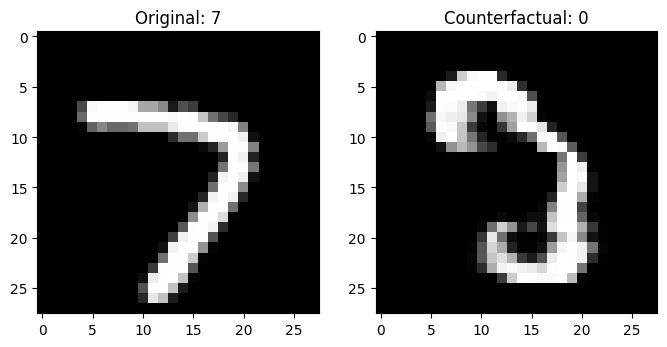

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 1


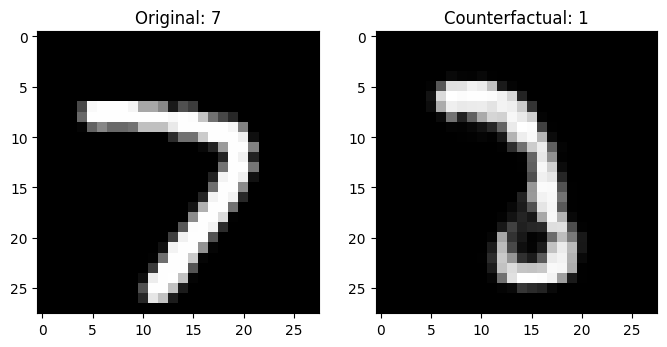

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 2


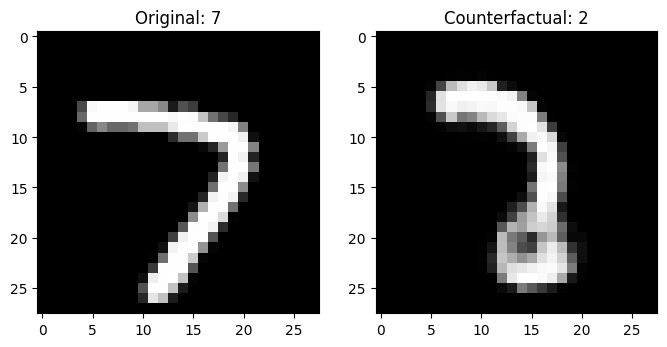

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 3


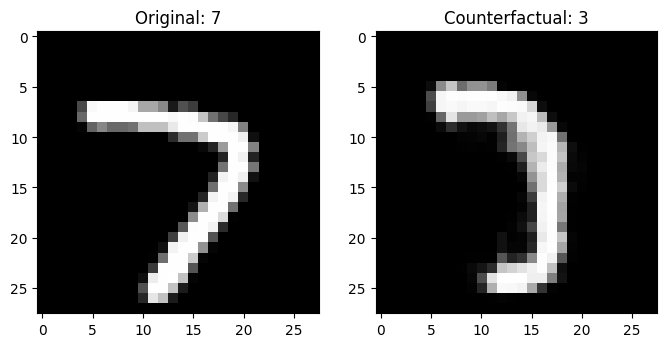

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 4


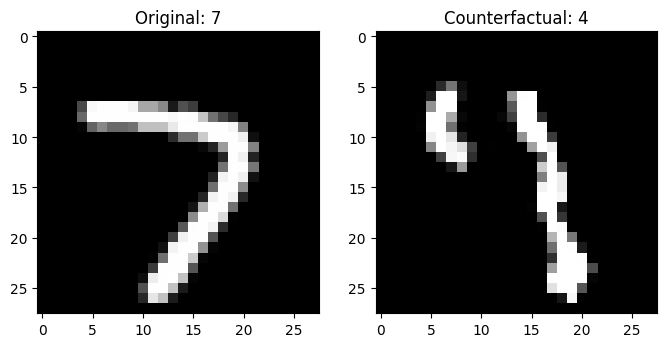

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 5


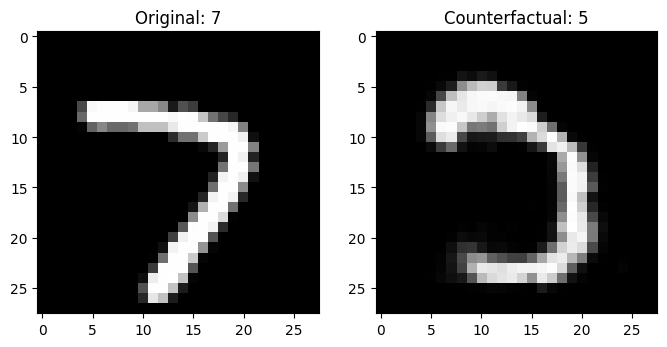

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 6


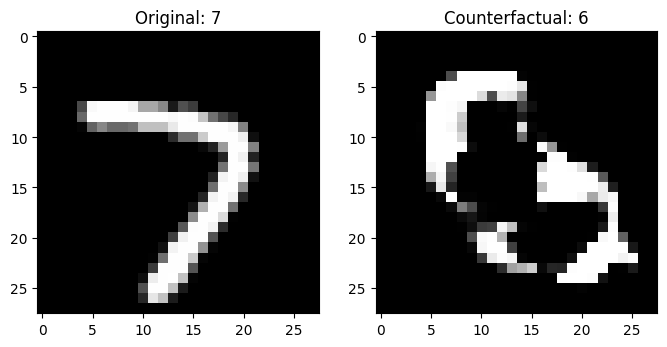

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 8


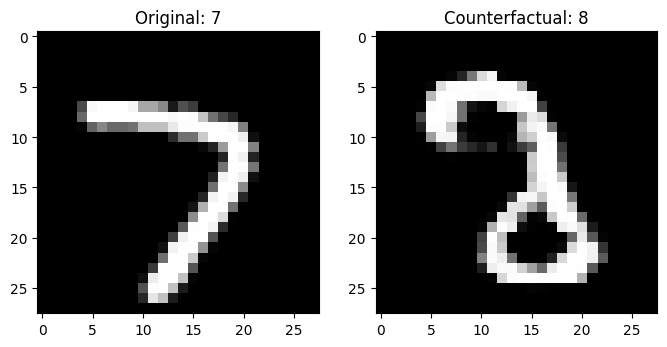

explainer: growing_spheres(step_size=0.1, max_radius=100, num_samples=200), original class: 7, target class: 9


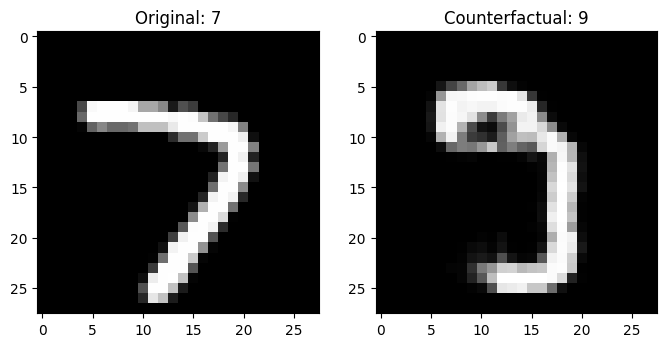

In [ ]:
for cf in counterfactuals:
    if cf:
        # cf = cf[0]
        latent_cf = torch.tensor(np.array(cf.data), dtype=torch.float32).reshape(latent_instance[0].shape).to(device)
        preds = latent_wrapper.predict(Dataset(
            data=cf.data,
            target=[cf.target_class],
            features=[f'l{i}' for i in range(16)],
            categorical_features=[],
            continuous_features=[f'l{i}' for i in range(16)],
            immutable_features=[],
            allowable_ranges=[]
        ))
        # print(f'Counterfactual predicted class: {preds[0]} (target: {cf.target_class})')
        print(f"explainer: {cf.explainer}, original class: {cf.original_class}, target class: {cf.target_class}")
        decoded_cf = decoder(latent_cf)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.imshow(instance_to_explain.cpu().squeeze().numpy(), cmap='gray')
        ax1.set_title(f'Original: {cf.original_class}')

        ax2.imshow(decoded_cf.cpu().detach().squeeze().numpy(), cmap='gray')
        ax2.set_title(f'Counterfactual: {cf.target_class}')

        plt.show()
    else:
        print('No counterfactual found.')
